In [ ]:
import tensorflow as tf
print(tf.__version__)
!python --version

2.8.0
Python 3.7.12


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/Weather Forecast Dataset

/content/gdrive/MyDrive/Weather Forecast Dataset


In [ ]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/Weather Forecast Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/gdrive/MyDrive/Weather Forecast Dataset/REMS_Mars_Dataset.csv
/content/gdrive/MyDrive/Weather Forecast Dataset/mars-weather.csv


In [ ]:
data=pd.read_csv('/content/gdrive/MyDrive/Weather Forecast Dataset/mars-weather.csv')

data.sample(5)

,id,terrestrial_date,sol,ls,month,min_temp,max_temp,pressure,wind_speed,atmo_opacity
813,1082,2015-11-01,1151,62,Month 3,-82.0,-31.0,901.0,NaN,Sunny
109,1786,2017-11-07,1868,84,Month 3,-80.0,-24.0,848.0,NaN,Sunny
1436,449,2014-01-18,516,77,Month 3,-86.0,-25.0,888.0,NaN,Sunny
1176,718,2014-10-12,776,212,Month 8,-72.0,5.0,841.0,NaN,Sunny
1835,208,2012-10-12,66,187,Month 7,-73.0,-2.0,778.0,NaN,Sunny


In [ ]:
data['terrestrial_date']=pd.to_datetime(data['terrestrial_date'])

data.terrestrial_date.sample(5)

1549   2013-09-04
641    2016-04-28
955    2015-06-07
1779   2012-12-09
584    2016-06-26
Name: terrestrial_date, dtype: datetime64[ns]

In [ ]:
data.iloc[:,6].isna().sum()

27

In [ ]:
import datetime as dt
data['month']=pd.to_datetime(data.terrestrial_date).dt.to_period('M')

data.month.value_counts()

2017-12    31
2013-01    31
2016-08    31
2014-05    31
2014-10    31
           ..
2015-01    23
2016-07    21
2012-08    18
2013-11    17
2013-03    11
Freq: M, Name: month, Length: 67, dtype: int64

In [ ]:
aa=data.iloc[:,6].name
ac=data.groupby(by='month')[aa].mean()
ab=data['max_temp'].isna()
data.loc[ab,['max_temp']]=data.loc[ab,'month'].apply(lambda x:ac[x])
data['max_temp'].isna().sum()

0

In [ ]:
new_df=pd.DataFrame(list(data['max_temp']),index=data.terrestrial_date,columns=['Maxtemperature'])


In [ ]:
new_df=new_df.resample('D').mean()

In [ ]:
from keras.layers import Bidirectional,LSTM,Dense,Flatten,Conv1D,MaxPooling1D,Dropout,RepeatVector
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stop=EarlyStopping(monitor='loss',patience=5)

In [ ]:
model=Sequential([Conv1D(100,kernel_size=3,input_shape=(30,1),activation='relu'),
                  Conv1D(100,kernel_size=3),
                  Conv1D(100,kernel_size=3),
                  MaxPooling1D(2),
                 Flatten(),
                  RepeatVector(30),
                 LSTM(128,activation='relu',return_sequences=True),
                 LSTM(128,activation='relu',return_sequences=True),
                  Bidirectional(LSTM(64,activation='relu')),
                 Dense(128,activation='relu'),
                 Dense(1)])

model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
new_df1=pd.DataFrame(list(data['max_temp']), index=data['terrestrial_date'], columns=['temp'])

In [ ]:
new_df1=new_df1.resample('D').mean()
new_df1.temp.isna().sum()

137

In [ ]:
new_df1.fillna(data['max_temp'].mean(),inplace=True)
new_df1.temp.isna().sum()

0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(-1,1))

In [ ]:
scaled_data=scaler.fit_transform(new_df1)
scaled_data[:5]

array([[ 0.06020067],
       [-0.02116299],
       [-0.02116299],
       [-0.02116299],
       [-0.02116299]])

In [ ]:
steps=30
inp1=[]
out1=[]

for i in range(len(scaled_data)-steps):
    inp1.append(scaled_data[i:i+steps])
    out1.append(scaled_data[i+steps])

In [ ]:
inp1=np.asanyarray(inp1)
out1=np.asanyarray(out1)
x_train1=inp1[:500,:,:]
x_test1=inp1[500:,:,:]
y_train1=out1[:500]
y_test1=out1[500:]

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [ ]:
model.fit(x_train1,y_train1,epochs=25)

Epoch 1/25
16/16 [==============================] - 6s 367ms/step - loss: 0.8731 - accuracy: 0.0000e+00
Epoch 2/25
16/16 [==============================] - 4s 248ms/step - loss: 0.5047 - accuracy: 0.0000e+00
Epoch 3/25
16/16 [==============================] - 4s 249ms/step - loss: 2409.6025 - accuracy: 0.0000e+00
Epoch 4/25
16/16 [==============================] - 4s 252ms/step - loss: 0.1252 - accuracy: 0.0000e+00
Epoch 5/25
16/16 [==============================] - 4s 252ms/step - loss: 0.1753 - accuracy: 0.0000e+00
Epoch 6/25
16/16 [==============================] - 4s 253ms/step - loss: 0.1424 - accuracy: 0.0000e+00
Epoch 7/25
16/16 [==============================] - 4s 250ms/step - loss: 0.0736 - accuracy: 0.0000e+00
Epoch 8/25
16/16 [==============================] - 4s 253ms/step - loss: 0.0425 - accuracy: 0.0000e+00
Epoch 9/25
16/16 [==============================] - 4s 257ms/step - loss: 0.0397 - accuracy: 0.0000e+00
Epoch 10/25
16/16 [==============================] - 4s 252ms

In [ ]:
predicted=model.predict(x_test1)

In [ ]:
predicted1=scaler.inverse_transform(predicted)

In [ ]:
y_test2=scaler.inverse_transform(y_test1)

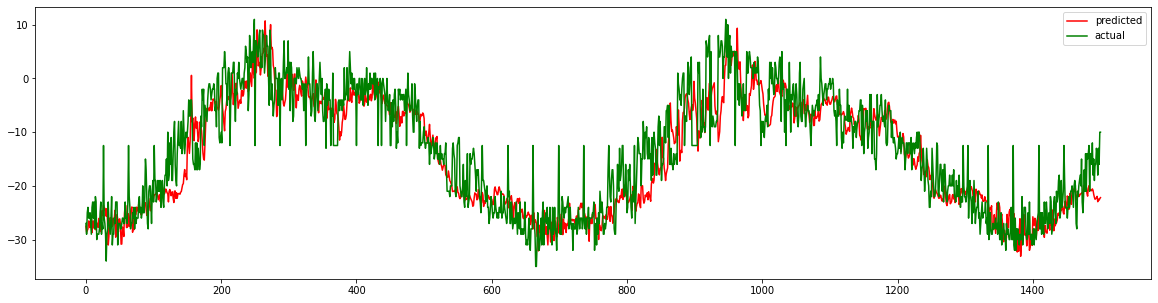

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(predicted1,'r',label='predicted')
plt.plot(y_test2,'g',label='actual')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save("/content/gdrive/MyDrive/Weather Forecast Dataset/LSTM_model.h5")